#### Import Cities

In [23]:
from functions import *

data = pd.read_csv('assets/cities.csv')
data.head()

,Name,Population,Size,Height
0,Naples,911_222,117.3,99.8
1,Padua,214_000,92.8,12.0
2,Oslo,634_293,454.0,1.0
3,Sao Paulo,12_330_000,1521.0,760.0
4,Singapore,5_076_700,710.0,164.0


In [24]:
#Put all city object in an array
cities = []
for city in data.iterrows():
    cities.append(
        City(city[1]['Name'],
             float(city[1]['Population']),
             float(city[1]['Size']*1_000_000),    #because i want m^2
             float(city[1]['Height']),
             ox.geocode_to_gdf(city[1]['Name'])))

naples = cities[0]
padua = cities[1]
oslo = cities[2]
saoPaulo = cities[3]
singapore = cities[4]
montreal = cities[5]

# print(naples.__str__())

#### Plots ####

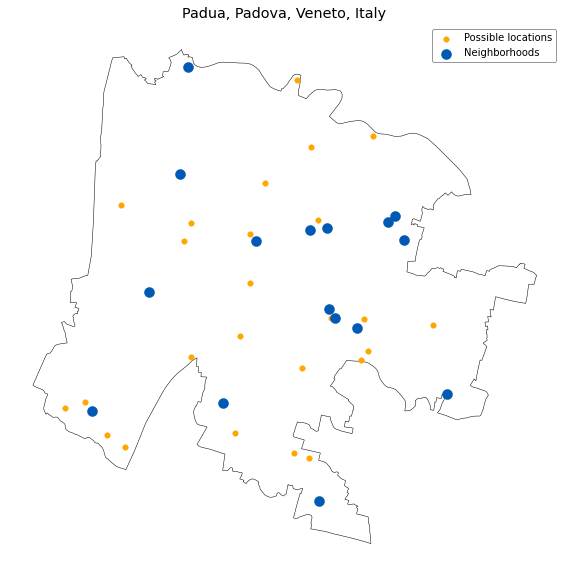

In [25]:
city = padua   # Define which city to analyze

hoods, plots = plotNeighboors(city)

In [26]:
print(hoods[0])
print(plots[0])

ID: 1
Coordinates:
X: 11.881
Y: 45.412
Population: 10000

ID: 1
Coordinates: 
X: 11.899
Y: 45.36
Size: 150



#### Variables ####

In [27]:
# d_j activation cost: defined by the size (mq) of the terrain
d_j = {i.id : i.size for i in plots}

# offer_j: how much the j-th plot offers
q = 1.5     # production %
offer_j = {i.id : i.size * q for i in plots}

# r_i demand by the i-th hood
k = 0.004   # demand %
r_i ={i.id : i.population * k for i in hoods}

# Connections cost
c_ij = computeCosts(hoods, plots)
# printDict(c_ij)

### Linear Model ###

In [28]:
i_hood = list(c_ij.keys())          # IDs of each hood
j_plot = [j.id for j in plots]      # IDs of each plot

# CFLP: 'Capacitated Facility Location Problem'
problem = LpProblem('CFLP', LpMinimize)

# Var: y_j (costraint: it's binary)
y_j = LpVariable.dicts('y', j_plot, 0, 1, LpBinary)

# Var: x_ij (costraint: it's binary)
x_ij = LpVariable.dicts('x', [(i, j) for i in i_hood for j in j_plot], 0, 1, LpBinary)

# Objective function
equalizer = 100
obj = lpSum(d_j[j] * y_j[j] for j in j_plot) +\
      lpSum(c_ij[i][j] * equalizer * x_ij[(i, j)] for i in i_hood for j in j_plot)

problem += obj

### DON'T TOUCH!! ###
# Costraint: each hood hass exaclty 1 plot connected to 
for i in i_hood:
    problem += lpSum(x_ij[(i, j)] for j in j_plot) == 1

# Costraint: connection i-j ==> j is active
for i in i_hood:
    for j in j_plot:
        problem += x_ij[(i, j)] <= y_j[j]

# Costraint: the demand must be met
for j in j_plot:
    problem += lpSum(r_i[i] * x_ij[(i, j)] for i in i_hood) <= offer_j[j]

# print(problem)

#### Solution ####

In [29]:
problem.solve()

if LpStatus[problem.status] == 'Optimal':
    print("Best solution found!")
else:
    print(f"Problem {LpStatus[problem.status]}")

Best solution found!


This is the minimum possible cost we can achieve under the given constraints. Any other choice in the number or location of the plots would lead to a higher value of the objective function.

In [30]:
print(np.round(value(problem.objective), 3))

3659.5


### Explore the results ###

Total locations selected: 9.
Build site at: [2, 8, 11, 15, 16, 20, 23, 24, 25]


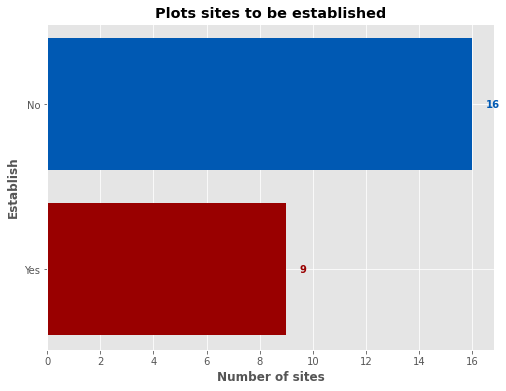

In [31]:
ids = summary(y_j)

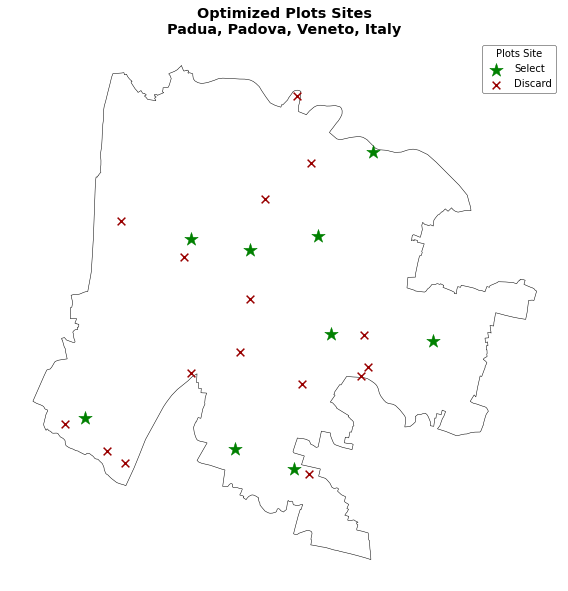

In [32]:
optimizedPlotSites(city, ids, plots)

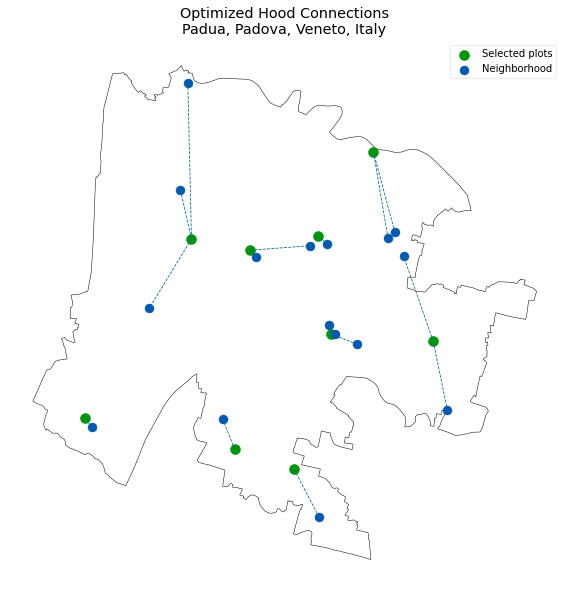

In [33]:
optimizedCity(city, hoods, plots, ids, x_ij)

With the following function we can execute all the functions above in 'one-shot' inserting only the name of the city as parameter, but we prefered to keep it commented to analyze every step we made to solve our problem.

In [34]:
# solveProblem(naples)

# PLANTS SECTION #

###  Function that returns the plants and the estimate of their yield ###

In this function, based on the land passed and their area, the yield will be calculated and, based on the geographical position, plants that are best suited to the climate will be suggested.

to start let's get the weather information for last year in the area to get an idea of ​​which plants can be grown

The monthly data are incomplete so I prefer to act on the daily ones and calculate the monthly average

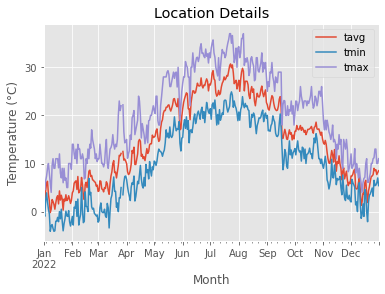

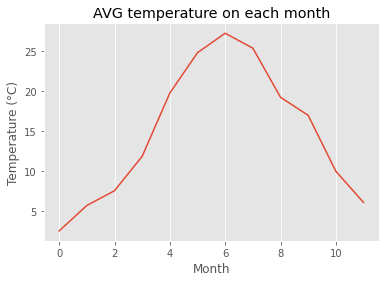

In [35]:
lat = city.gdf['lat'][0]
lon = city.gdf['lon'][0]
height = city.height

med, emisfero = locationDetails(lat, lon, height)

Now we have the average temperature for each month of the place, we can move on to checking the plants to establish which ones can tolerate these temperatures

first I create a function that returns the month number based on the name, but in the case of southern hemisphere the number + 6 will be returned to take into account the seasonal difference

In [36]:
Piante_DF = pd.read_csv(r'assets/plants.csv')
display(Piante_DF)

,Plants,MONTHS landfill,MONTHS landfill 2,PRODUCTION TIME (weeks),MINIMUM TEMPERATURE,MAXIMUM TEMPERATURE,YIELD PER SQM
1,GARLIC,October-February,NaN,16,-5,25,1.0
2,BROCCOLI,March-April,NaN,16,5,35,1.0
3,CARROTS,February-September,NaN,10,15,35,4.0
4,KALE,April-September,NaN,8,5,35,1.0
5,ONIONS,October-November,March-May,12,0,30,3.0
6,GREEN BEANS,January-December,NaN,7,10,35,3.0
7,CHICORY,February-March,July-September,8,5,25,3.0
8,LETTUCE,April-July,NaN,6,10,25,3.0
9,EGGPLANT,March-June,NaN,9,15,35,4.0
10,MELON,March-June,NaN,10,15,40,3.0


Now I create the function that tests if the plant can survive based on the temperature.

I return a DataFrame sorted based on the return for mq optimized for that specific location

In [37]:
Piante_DF['YIELD PER SQM']


1      1.0
2      1.0
3      4.0
4      1.0
5      3.0
6      3.0
7      3.0
8      3.0
9      4.0
10     3.0
11     4.0
12     0.5
13     4.0
14     1.0
15     4.0
16     3.0
17     2.0
18     5.0
19    13.0
20     3.0
Name: YIELD PER SQM, dtype: float64

In [38]:
plantsOK = plantSuggestions(Piante_DF, emisfero, med)
plantsOK = plantsOK.sort_values('YIELD PER SQM', ascending=False)
print("The following plants are suggested by the \'YIELD PER SQM\'")
display(plantsOK)

The following plants are suggested by the 'YIELD PER SQM'


,Plants,MONTHS landfill,MONTHS landfill 2,PRODUCTION TIME (weeks),MINIMUM TEMPERATURE,MAXIMUM TEMPERATURE,YIELD PER SQM
16,PUMPKIN,March-June,NaN,15,15,40,13.0
8,EGGPLANT,March-June,NaN,9,15,35,4.0
2,CARROTS,February-September,NaN,10,15,35,4.0
12,BELL PEPPER,March-June,NaN,8,15,40,4.0
10,POTATOES,February-March,September-October,16,10,25,4.0
9,MELON,March-June,NaN,10,15,40,3.0
14,RADICCHIO,May-July,NaN,8,-5,25,3.0
17,ZUCCHINI,February-August,NaN,6,10,40,3.0
7,LETTUCE,April-July,NaN,6,10,25,3.0
6,CHICORY,February-March,July-September,8,5,25,3.0


Now that I have the list of plants available, I average their yield assuming that the garden is made up of a variety of these plants and not just one species

In [39]:
# Select a random plot among the ids list to analize
rdm = rand.choice(ids)
plotSize = [j.size for j in plots if j.id == rdm][0]

print(f'Average Yeld for the plot (ID: {rdm}): {np.round(yeldAvg(plantsOK, plotSize), 3)} kg/mq')

Average Yeld for the plot (ID: 23): 517.917 kg/mq
